In [1]:
!pip install torch torchvision umap-learn scikit-learn matplotlib adversarial-robustness-toolbox
!pip install pytorch-metric-learning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 1.5 MB/s eta 0:00:00a 0:00:01m


In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from umap import UMAP
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.backends.cudnn as cudnn
from torch.autograd import *
from torchvision.transforms.functional import resize
import torchvision
import torchvision.transforms as transforms
import os
import umap
import matplotlib.pyplot as plt
import argparse
import torch.optim as optim
from pytorch_metric_learning import losses
import pickle
from umap import UMAP
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from umap import UMAP

2024-04-15 13:31:28.171089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 13:31:28.171205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 13:31:28.341883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def calculate_dataset_stats():
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [5]:
mean, std = calculate_dataset_stats()

100%|██████████| 170498071/170498071 [00:02<00:00, 83007279.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
print(f"Calculated Mean: {mean}")

Calculated Mean: tensor([0.4914, 0.4822, 0.4465])


In [7]:
print(f"Calculated Std: {std}")

Calculated Std: tensor([0.2023, 0.1994, 0.2010])


In [8]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [9]:
def create_balanced_split(dataset, samples_per_class=4000):
    class_indices = [[] for _ in range(10)]

    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    train_indices = []
    for indices in class_indices:
        np.random.shuffle(indices)
        train_indices.extend(indices[:samples_per_class])

    # Use the remaining indices for validation
    val_indices = list(set(range(len(dataset))) - set(train_indices))

    return Subset(dataset, train_indices), Subset(dataset, val_indices)

In [10]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

Files already downloaded and verified


In [11]:
train_subset, val_subset = create_balanced_split(train_dataset)

In [12]:
def count_samples_per_class(dataset):
    class_counts = {i: 0 for i in range(10)}

    for index in dataset.indices:
        label = dataset.dataset.targets[index]
        class_counts[label] += 1

    return class_counts

In [13]:
train_class_counts = count_samples_per_class(train_subset)
print("Training class counts:", train_class_counts)

Training class counts: {0: 4000, 1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000, 9: 4000}


In [14]:
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

In [15]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

class MyResNet18(nn.Module):
    def __init__(self, pretrained=True):
        super(MyResNet18, self).__init__()
        self.base_model = models.resnet18(pretrained=pretrained)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 128)

    def forward(self, x):
        features = self.base_model(x)
        normalized_features = F.normalize(features, p=2, dim=1)
        return normalized_features

# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyResNet18().to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s] 


In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = losses.CircleLoss(m=0.5, gamma=25)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [17]:
def FGSM(model, x, y, eps):

        x_ = Variable(x.data, requires_grad=True)
        h_ = model(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        model.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()

        x_adv = x_ + pert

        h_adv = model(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert

In [18]:
def perturb_image(image, num_pixels=15):

    perturbed_image = image.clone()

    for _ in range(num_pixels):
        x = random.randint(0, image.size(2) - 1)
        y = random.randint(0, image.size(3) - 1)
        perturbed_image[:, :, x, y] = torch.rand_like(perturbed_image[:, :, x, y])

    return perturbed_image

In [19]:
def create_adversarial_dataset(model, test_loader, epsilon):
    adversarial_examples = []
    original_labels = []
    adversarial_labels = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        perturbed_inputs = perturb_image(inputs)
        adv_inputs, _, adv_labels, _ = FGSM(model, perturbed_inputs, labels, epsilon)

        adversarial_examples.append(adv_inputs)
        original_labels.append(labels)
        adversarial_labels.append(adv_labels)

    adversarial_examples = torch.cat(adversarial_examples, dim=0).to(device)
    original_labels = torch.cat(original_labels, dim=0).to(device)
    adversarial_labels = torch.cat(adversarial_labels, dim=0).to(device)

    return adversarial_examples, original_labels, adversarial_labels

In [20]:
epsilon = 0.1
num_pixels = 15

In [21]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()  
    total_loss = 0
    correct = 0
    total = 0
    for data, targets in train_loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()  
        outputs = model(data)  
        loss = criterion(outputs, targets)  
        loss.backward()  
        optimizer.step()  

        total_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    average_loss = total_loss / total
    accuracy = 100 * correct / total
    return average_loss, accuracy

In [22]:
def validate(model, val_loader, criterion, device):
    model.eval() 
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): 
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    average_loss = total_loss / total
    accuracy = 100 * correct / total
    return average_loss, accuracy

In [23]:
def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch 1: Train Loss 9.6018, Train Acc 0.71%, Val Loss 9.6491, Val Acc 0.91%
Epoch 2: Train Loss 8.9560, Train Acc 1.08%, Val Loss 9.4717, Val Acc 1.52%
Epoch 3: Train Loss 8.6609, Train Acc 1.04%, Val Loss 8.8364, Val Acc 1.42%
Epoch 5: Train Loss 8.2500, Train Acc 0.70%, Val Loss 8.4939, Val Acc 0.45%
Epoch 6: Train Loss 8.0619, Train Acc 0.71%, Val Loss 8.4504, Val Acc 0.49%
Epoch 7: Train Loss 7.9336, Train Acc 0.58%, Val Loss 8.2480, Val Acc 0.21%
Epoch 8: Train Loss 7.8023, Train Acc 0.67%, Val Loss 7.9599, Val Acc 0.58%
Epoch 9: Train Loss 7.6458, Train Acc 0.50%, Val Loss 7.9987, Val Acc 0.71%
Epoch 10: Train Loss 7.5349, Train Acc 0.88%, Val Loss 8.0710, Val Acc 0.42%
Epoch 11: Train Loss 7.4405, Train Acc 1.18%, Val Loss 7.7863, Val Acc 1.26%
Epoch 12: Train Loss 7.3384, Train Acc 0.94%, Val Loss 7.6115, Val Acc 0.27%
Epoch 13: Train Loss 7.2473, Train Acc 0.88%, Val Loss 7.6180, Val Acc 0.34%
Epoch 14: Train Loss 7.1218, Train Acc 0.98%, Val Loss 7.6661, Val Acc 0.69%
Epoch 1

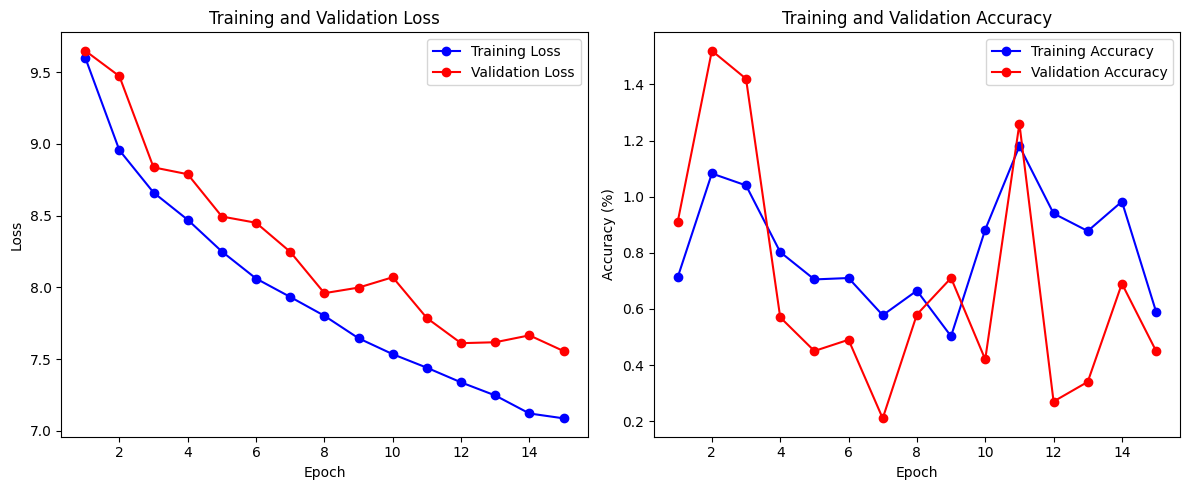

In [24]:
num_epochs = 15

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_accuracy:.2f}%, Val Loss {val_loss:.4f}, Val Acc {val_accuracy:.2f}%')

plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies)


In [25]:
test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test), batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified


In [26]:
adversarial_test, original_labels_test, adversarial_labels_test = create_adversarial_dataset(model, test_loader, epsilon)
adv_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(adversarial_test, original_labels_test), batch_size=64, shuffle=True)
print("Adversarial dataset created and saved successfully!")


Adversarial dataset created and saved successfully!


In [27]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [28]:
def extract_features(model, loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, labels_batch in loader:
            images = images.to(device)
            outputs = model(images)
            features.extend(outputs.cpu().detach().numpy())
            labels.extend(labels_batch.numpy())
    return features, labels

In [30]:
features_train, labels_train = extract_features(model, train_loader, device)
features_test, labels_test = extract_features(model, test_loader, device)


In [31]:
def extract_features(model, loader, device):
    model.to(device)
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            outputs = model(data)
            features.extend(outputs.cpu().numpy())  # Move outputs to CPU before converting to NumPy
            labels.extend(targets.cpu().numpy())   # Move targets to CPU before converting to NumPy
    return features, labels


In [32]:
features_adversarial, labels_adversarial = extract_features(model, adv_test_loader, device)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(features_train, labels_train)

KNeighborsClassifier()

In [33]:
y_pred = knn.predict(features_test)
print('KNN Accuracy:', accuracy_score(labels_test, y_pred))

KNN Accuracy: 0.751


In [34]:
y_pred = knn.predict(features_adversarial)
print('KNN Accuracy:', accuracy_score(labels_adversarial, y_pred))

KNN Accuracy: 0.5163


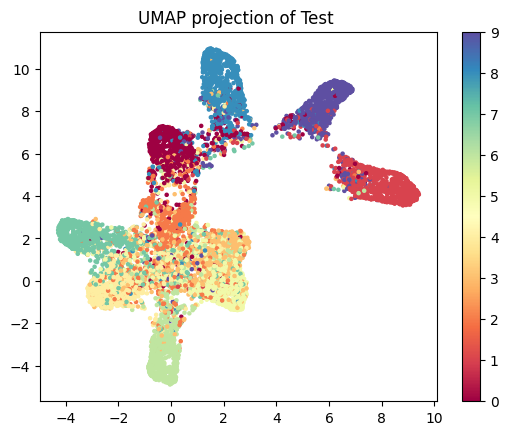

In [35]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_test)
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_test, cmap='Spectral', s=5)
plt.title('UMAP projection of Test ')
plt.colorbar()
plt.show()

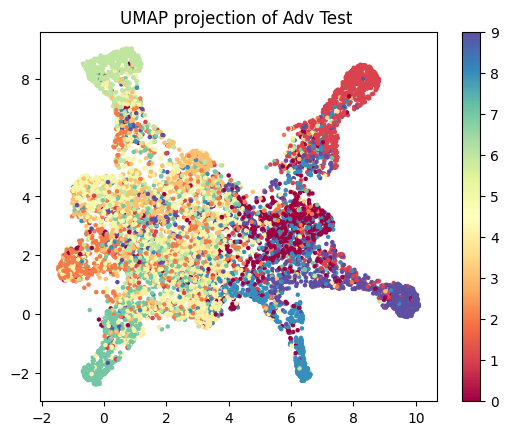

In [48]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_adversarial)
plt.scatter(embedding[:, 0], embedding[:, 1], c=labels_adversarial, cmap='Spectral', s=5)
plt.title('UMAP projection of Adv Test ')
plt.colorbar()
plt.show()